In [1]:
import os
import shutil
import glob
import subprocess
import pandas as pd
import geopandas as gpd
import dask
from dask.distributed import Client, progress, LocalCluster
from pyFIRS.wrappers import lastools, fusion
from pyFIRS.utils import clean_dir, clean_buffer_polys, clip_tile_from_shp, convert_project, PipelineError

### Setting up parallel computing using `dask.distributed`
`LAStools` offers native multi-core processing as an optional argument (`cores`) supplied to its command-line tools. `FUSION` command line tools do not. To enable parallel processing of `FUSION` commands, we'll use `dask.distributed` to schedule the processing of tiles in asynchronous parallel batches. This approach also offers us the ability to track progress using a progress bar.

You'll first need to launch a parallel computing cluster. 

In [2]:
cluster=LocalCluster(scheduler_port=7001, diagnostics_port=7002)
c = Client(cluster)
num_cores = len(c.ncores()) # identify how many workers we have

At this point, you should also be able to view an interactive dashboard on port 7002. If you're executing this on a remote server, you'll need to set up port forward so you can view the dashboard on your local machine's browser. Once you've done that, or if you're processing on your own machine, you can view the dashboard at [http://localhost:7002/status](http://localhost:7002/status).

# Let's get to work with some lidar data

We'll define where we can find the binary executables for LAStools and FUSION command line tools.

In [3]:
las = lastools.useLAStools('/storage/lidar/LAStools/bin')
fus = fusion.useFUSION('/storage/lidar/FUSION/')

We'll create working directories for raw (imported with modest clean-up from source files), interim, and processed data.

In [4]:
# where the imported lidar data is currently stored
workdir = os.path.abspath('/storage/lidar/odf_northwest_2015/wilkerson/')
# define data handling directories
interim = os.path.join(workdir,'interim')
processed = os.path.join(workdir,'processed')
layers = os.path.join(interim, 'layers')


# the coordinate reference system we'll be working with
target_epsg = 26910 # utm 10 N

In [5]:
def log_error(tile_id, process, error_msg):
    logfile = os.path.join(interim, 'failed', tile_id + '.txt')
    os.makedirs(os.path.dirname(logfile), exist_ok=True)
    
    with open(logfile, '+w') as f:
        f.write('{} | {}: {}'.format(tile_id, process, error_msg))
    
    return

def has_error(tile_id):
    errors = glob.glob(os.path.join(interim, 'failed', '*.txt'))
    tiles_with_errors = [os.path.basename(error).split('.')[0] for error in errors]
    if tile_id in tiles_with_errors:
        return True
    else:
        return False

In [6]:
# push our working directories and wrapper classes to the workers on the cluster as well
c.scatter([interim, processed, layers, las, fus, target_epsg, num_cores, has_error, log_error], broadcast=True);

## 1. Classify points in the lidar point cloud

If the original tiles delivered by the vendor included overlapping edges, our retiling may result in duplicated points in the new tiles from overlapping edges of vendor-provided input tiles. In the next step, we will ensure that only one point with unique (X,Y,Z) coordinates are retained in the point cloud data.

In [7]:
@dask.delayed
def remove_duplicate_points(tile_id):
    if not os.path.exists(os.path.join(interim, 'layers', tile_id + '.lay')):
        try:
            proc = las.lasduplicate(i=os.path.join(interim, 'retiled', tile_id + '.laz'),
                                    unique_xyz=True,
                                    olay=True,
                                    olaydir=layers,
                                    odir=layers)
        except PipelineError as e:
            log_error(tile_id, 'remove_duplicate_points', e.message)
    else: # output file already exists
        pass
    
    return tile_id

Now we'll remove points that are isolated as likely noise.

In [8]:
@dask.delayed
def denoise(tile_id):    
    if not has_error(tile_id):
        try:
            proc = las.lasnoise(i=os.path.join(interim, 'retiled', tile_id + '.laz'),
                                remove_noise=True,
                                ilaydir=layers,
                                olay=True,
                                olaydir=layers)
        except PipelineError as e:
            log_error(tile_id, 'denoise', e.message)
    
    else: # this tile already has an error recorded in the error_log
        pass
    
    return tile_id

Next, calculate the height aboveground for each point for use in classifying them.

In [9]:
@dask.delayed
def height_above_ground(tile_id):
    if not has_error(tile_id):
        try:
            proc = las.lasheight(i=os.path.join(interim, 'retiled', tile_id + '.laz'),
                                 ilaydir=layers,
                                 olay=True,
                                 olaydir=layers)
        except PipelineError as e:
            log_error(tile_id, 'height_above_ground', e.message)
    
    else: # this tile already has an error recorded in the error_log
        pass
    
    return tile_id

Now, we'll classify points as building or high vegetation that meet certain criteria for 'planarity' or 'ruggedness'. 

**THERE ARE ARGUMENTS IN THE FOLLOWING COMMAND THAT DEPEND UPON THE UNITS OF THE DATA.**

If your data are in meters, you should change these parameters, or consider reprojecting the data to a projection that is in feet when you copy the source data into our working directory using the `import_tiles` / `las2las` command at the top of this notebook.

In [10]:
@dask.delayed
def classify(tile_id):
    if not has_error(tile_id):
        try:
            proc = las.lasclassify(i=os.path.join(interim, 'retiled', tile_id + '.laz'),
                                   ilaydir=layers,
                                   step=2.0, # if your data are in meters
                                   planar=0.1, # if your data are in meters
                                   rugged=0.4, # if your data are in meters
                                   olaz=True,
                                   odir=os.path.join(interim, 'classified'))
        except PipelineError as e:
            log_error(tile_id, 'classify', e.message)
    
    else: # this tile already has an error recorded in the error_log
        pass
    
    return tile_id

We'll now remove the points in the buffered area of each tile and put the clean tiles in the processed folder.

In [11]:
@dask.delayed
def remove_point_buffer(tile_id):
    odir = os.path.join(processed, 'points')
    outfile = os.path.join(odir, tile_id + '.laz')
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = las.las2las(i=os.path.join(interim, 'classified', tile_id + '.laz'),
                                   drop_withheld=True, # remove points flagged as withhled
                                   set_user_data=0, # remove height aboveground calculated using lasheight
                                   olaz=True, # compress outputs to LAZ format
                                   odir=odir)
            except PipelineError as e:
                log_error(tile_id, 'remove_point_buffer', e.message)
    else: # output file already exists
        pass
    
    return tile_id

## 2. Generate a bare earth Digital Elevation Model
Generate tiles of the bare earth model. This assumes that there are already ground-classified points

In [12]:
@dask.delayed
def make_dem(tile_id):
    odir = os.path.join(processed, 'rasters', 'DEM_tiles')
    outfile = os.path.join(odir, tile_id + '.tif')
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try: 
                proc = las.las2dem(i=os.path.join(interim, 'classified', tile_id + '.laz'),
                                   odir=os.path.join(processed, 'rasters', 'DEM_tiles'),
                                   otif=True, # create tiles as GeoTiff rasters
                                   keep_class=2, # keep ground-classified returns only
                                   step=1, # resolution of output raster, in units of lidar data
                                   thin_with_grid=1, # use a 1 x 1 resolution for creating the TIN for the DEM
                                   extra_pass=True, # uses two passes over data to execute DEM creation more efficiently
                                   use_tile_bb=True) # remove buffers from tiles
            except PipelineError as e:
                log_error(tile_id, 'make_dem', e.message)
    else: # output file already exists
        pass
        
    return tile_id

In [13]:
@dask.delayed
def add_dem_projection(tile_id):
    basename = tile_id + '.tif'
    infile = os.path.join(processed, 'rasters', 'DEM_tiles', basename)
    
    if not has_error(tile_id):
        proc = subprocess.run(['rio', 'edit-info', '--crs', 'EPSG:{}'.format(target_epsg), infile],
                              stderr=subprocess.PIPE, stdout=subprocess.PIPE)
        if proc.returncode != 0:
            log_error(tile_id, 'add_dem_projection', proc.stderr.decode())
    
    return tile_id

To create a hillshade layer, we'll first, generate hillshade tiles from the bare earth model.

In [14]:
@dask.delayed
def make_hillshade(tile_id):
    odir = os.path.join(processed, 'rasters', 'hillshade_tiles')
    outfile = os.path.join(odir, tile_id + '.tif')
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try: 
                proc = las.las2dem(i=os.path.join(interim, 'classified', tile_id + '.laz'),
                       odir=odir,
                       otif=True, # create tiles as GeoTiffs
                       hillshade=True,
                       keep_class=2, # keep ground-classified returns only
                       step=1, # resolution of output raster, in units of lidar data
                       thin_with_grid=1, # use a 0.5 x 0.5 resolution for creating the TIN for the DEM
                       extra_pass=True, # uses two passes over data to execute DEM creation more efficiently
                       use_tile_bb=True) # remove buffers from tiles
            
            except PipelineError as e:
                log_error(tile_id, 'make_hillshade', e.message)
    else: # output file already exists
        pass
        
    return tile_id

In [15]:
@dask.delayed
def add_hillshade_projection(tile_id):
    basename = tile_id + '.tif'
    infile = os.path.join(processed, 'rasters', 'hillshade_tiles', basename)
    
    if not has_error(tile_id):
        proc = subprocess.run(['rio', 'edit-info', '--crs', 'EPSG:{}'.format(target_epsg), infile],
                              stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    
        if proc.returncode != 0:
                log_error(tile_id, 'add_hillshade_projection', proc.stderr.decode())
    
    return tile_id

## 3. Identify building footprints
First start by building shapefiles showing building boundaries in each buffered tile.

In [16]:
@dask.delayed
def make_building_footprint_tiles(tile_id):
    odir = os.path.join(interim, 'building_tiles')
    outfile = os.path.join(odir, tile_id + '.shp')
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = las.lasboundary(i=os.path.join(interim, "retiled", tile_id + '.laz'),
                                       ilaydir=layers,
                                       keep_class=6, # use only building-classified points
                                       disjoint=True, # compute separate polygons for each building
                                       concavity=1, # map concave boundary if edge length >= 1m
                                       oshp=True,
                                       odir=odir)
            except PipelineError as e:
                log_error(tile_id, 'make_building_footprint_tiles', e.message)
    else: # output file already exists
        pass
        
    return tile_id

Generate shapefiles showing the bounding box of each (unbuffered) tile that we'll use to remove buildings that fall in the buffered area.

In [17]:
@dask.delayed
def unbuffered_tile_boundary(tile_id):
    odir = os.path.join(interim, 'tile_boundaries')
    outfile = os.path.join(odir, tile_id + '.shp')
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = las.lasboundary(i=os.path.join(processed, 'points', tile_id + '.laz'),
                                       odir=odir,
                                       oshp=True,
                                       use_tile_bb=True)
            except PipelineError as e:
                log_error(tile_id, 'unbuffered_tile_boundary', e.message)
    else: # output file already exists
        pass
        
    return tile_id

For each shapefile containing polygons of the building boundaries, we'll use the `clean_buffer_polys` function from `pyFIRS.utils` to remove polygons from a tile if their centroid falls in the buffered area of the tile.

In [18]:
@dask.delayed
def remove_building_buffers(tile_id, *args):
    if type(tile_id) == list:
        tile_id = tile_id[0]

    basename = tile_id + '.shp'
    infile = os.path.join(interim, 'building_tiles', basename)
    tile_shp = os.path.join(interim, 'tile_boundaries', basename)
    odir = os.path.join(processed, 'vectors', 'building_tiles')
    outfile = os.path.join(odir, basename)
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                clean_buffer_polys(infile,
                                   tile_shp,
                                   odir=odir,
                                   simp_tol=3,
                                   simp_topol=True)
            except Exception as e:
                log_error(tile_id, 'remove_building_buffers', e.message)
    else: # output file already exists
        pass
        
    return tile_id

## 4. Create a Canopy Height Model
We're going to switch use a FUSION command line tool to generate a Canopy Height Models (CHMs). 

### Using FUSION's `canopymodel` to generate CHMs
`FUSION` wants to have ground models formatted as .dtm files, for CHM development and for estimating other canopy metrics. Let's generate these ground models first using a 1-meter x-y resolution.

In [19]:
@dask.delayed
def make_ground_dtm(tile_id):
    infile = os.path.join(interim, 'classified', tile_id + '.laz')
    odir = os.path.join(interim, 'dtm_ground_tiles')
    outfile = os.path.join(odir, tile_id + '.dtm')
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = fus.gridsurfacecreate(surfacefile=outfile,
                                             cellsize=1,
                                             xyunits='M',
                                             zunits='M',
                                             coordsys=1, # in UTM
                                             zone='10N',
                                             horizdatum=2, # NAD83
                                             vertdatum=2, # NAVD88
                                             datafile=infile,
                                             las_class=2, # keep only ground-classified points
                                             odir=odir) # will make sure output directory is created if doesn't already exist
            except PipelineError as e:
                log_error(tile_id, 'make_ground_dtm', e.message)
    else: # output file already exists
        pass
                
    return tile_id

In [20]:
@dask.delayed
def make_canopy_model(tile_id):
    infile = os.path.join(interim, 'classified', tile_id + '.laz')
    odir = os.path.join(interim, 'chm_tiles')
    outfile = os.path.join(odir, tile_id + '.dtm')
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = fus.canopymodel(surfacefile=outfile,
                                       cellsize=0.5, # in meters
                                       xyunits='M',
                                       zunits='M',
                                       coordsys=1, # in UTM
                                       zone='10N', # not in UTM
                                       horizdatum=2, # NAD83
                                       vertdatum=2, # NAVD88
                                       datafiles=infile,
                                       ground=os.path.join(interim, 'dtm_ground_tiles', tile_id + '.dtm'),
                                       median=3, # median smoothing in 3x3 kernel
                                       las_class=(1,2,5), # keep only ground, unclassified, and high veg points
                                       asc=True, # also output in ascii format
                                       odir=odir) # will make sure output directory is created if doesn't already exist
                
            except PipelineError as e:
                        log_error(tile_id, 'make_canopy_model', e.message)
    else: # output file already exists
        pass
                
    return tile_id

Convert the ascii files that `canopymodel` generated into GeoTiffs, specifying their projection. Then cleanup the files `canopymodel` generated that we don't care about.

In [21]:
@dask.delayed
def asc2tif(tile_id):
    infile = os.path.join(interim, 'chm_tiles', tile_id + '.asc')
    outfile = os.path.join(interim, 'chm_tiles', tile_id + '.tif')
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                convert_project(infile, '.tif', 'EPSG:{}'.format(target_epsg))
            except Exception as e:
                log_error(tile_id, 'asc2tif', e.message)
    else: # output file already exists
        pass
    
    return tile_id

Clip the canopy height model tiles to remove overlapping areas that were from tile buffering to avoid edge effects.

In [22]:
@dask.delayed
def remove_canopy_model_buffer(tile_id, *args):
    if type(tile_id) == list:
        tile_id = tile_id[0]
        
    infile = os.path.join(interim, 'chm_tiles', tile_id + '.tif')
    in_shp = os.path.join(interim, 'tile_boundaries', tile_id + '.shp')
    odir = os.path.join(processed, 'rasters', 'chm_tiles')
    outfile = os.path.join(odir, tile_id + '.tif')
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                clip_tile_from_shp(infile, in_shp, odir)
            
            except Exception as e:
                log_error(tile_id, 'remove_canopy_model_buffer', e.message)
    else: # output file already exists
        pass
    
    return tile_id

In [23]:
@dask.delayed
def tile_done(tile_id, *args, **kwargs):
    if type(tile_id) == list:
        tile_id = tile_id[0]
        
    outfile = os.path.join(interim, 'finished', tile_id + '.txt')
    os.makedirs(os.path.dirname(outfile), exist_ok=True)
    
    with open(outfile, '+a') as f:
        f.write('{}'.format(tile_id))
    
    return tile_id

@dask.delayed
def tiles_done(*args, **kwargs):
    return

## Hand-build the computational graph
Define the recipe for computations.

In [24]:
tile_ids = [os.path.basename(file).split('.')[0] for file in glob.glob(os.path.join(interim, 'retiled', '*.laz'))]
print('Found {:,d} tiles to process'.format(len(tile_ids)))
print(tile_ids[0:5])

Found 397 tiles to process
['491000_5080000', '492000_5080000', '492000_5081000', '491000_5081000', '491000_5082000']


In [25]:
dsk = {}
for tile in tile_ids:
    dsk['deduped-{}'.format(tile)]=(remove_duplicate_points, tile)
    dsk['denoised-{}'.format(tile)]=(denoise, 'deduped-{}'.format(tile))
    dsk['normalized-{}'.format(tile)]=(height_above_ground, 'denoised-{}'.format(tile))
    dsk['classified-{}'.format(tile)]=(classify, 'normalized-{}'.format(tile))
    dsk['unbuffered-{}'.format(tile)]=(remove_point_buffer, 'classified-{}'.format(tile))
    dsk['bbox-{}'.format(tile)]=(unbuffered_tile_boundary, 'unbuffered-{}'.format(tile))
    dsk['dem-{}'.format(tile)]=(make_dem, 'classified-{}'.format(tile))
    dsk['projected_dem-{}'.format(tile)]=(add_dem_projection, 'dem-{}'.format(tile))
    dsk['hillshade-{}'.format(tile)]=(make_hillshade, 'classified-{}'.format(tile))
    dsk['projected_hillshade-{}'.format(tile)]=(add_hillshade_projection, 'hillshade-{}'.format(tile))
    dsk['buildings_buffered-{}'.format(tile)]=(make_building_footprint_tiles, 'classified-{}'.format(tile))
    dsk['buildings_unbuffered-{}'.format(tile)]=(remove_building_buffers, 
                                                 ['buildings_buffered-{}'.format(tile), 'bbox-{}'.format(tile)])
    dsk['ground_dtm-{}'.format(tile)]=(make_ground_dtm, 'classified-{}'.format(tile))
    dsk['canopy-{}'.format(tile)]=(make_canopy_model, 'ground_dtm-{}'.format(tile))
    dsk['canopy_tif-{}'.format(tile)] = (asc2tif, 'canopy-{}'.format(tile))
    dsk['canopy_clipped-{}'.format(tile)]=(remove_canopy_model_buffer, ['canopy_tif-{}'.format(tile), 'bbox-{}'.format(tile)])
    dsk['tile_done-{}'.format(tile)]=(tile_done, ['unbuffered-{}'.format(tile),
                                                  'projected_dem-{}'.format(tile),
                                                  'projected_hillshade-{}'.format(tile),
                                                  'buildings_unbuffered-{}'.format(tile),
                                                  'canopy_clipped-{}'.format(tile)])
    
dsk['tiles_done'] = (tiles_done, ['tile_done-{}'.format(tile) for tile in tile_ids])

The computational pipeline, including dependencies of each step in the pipeline, can be specified using a dictionary. 

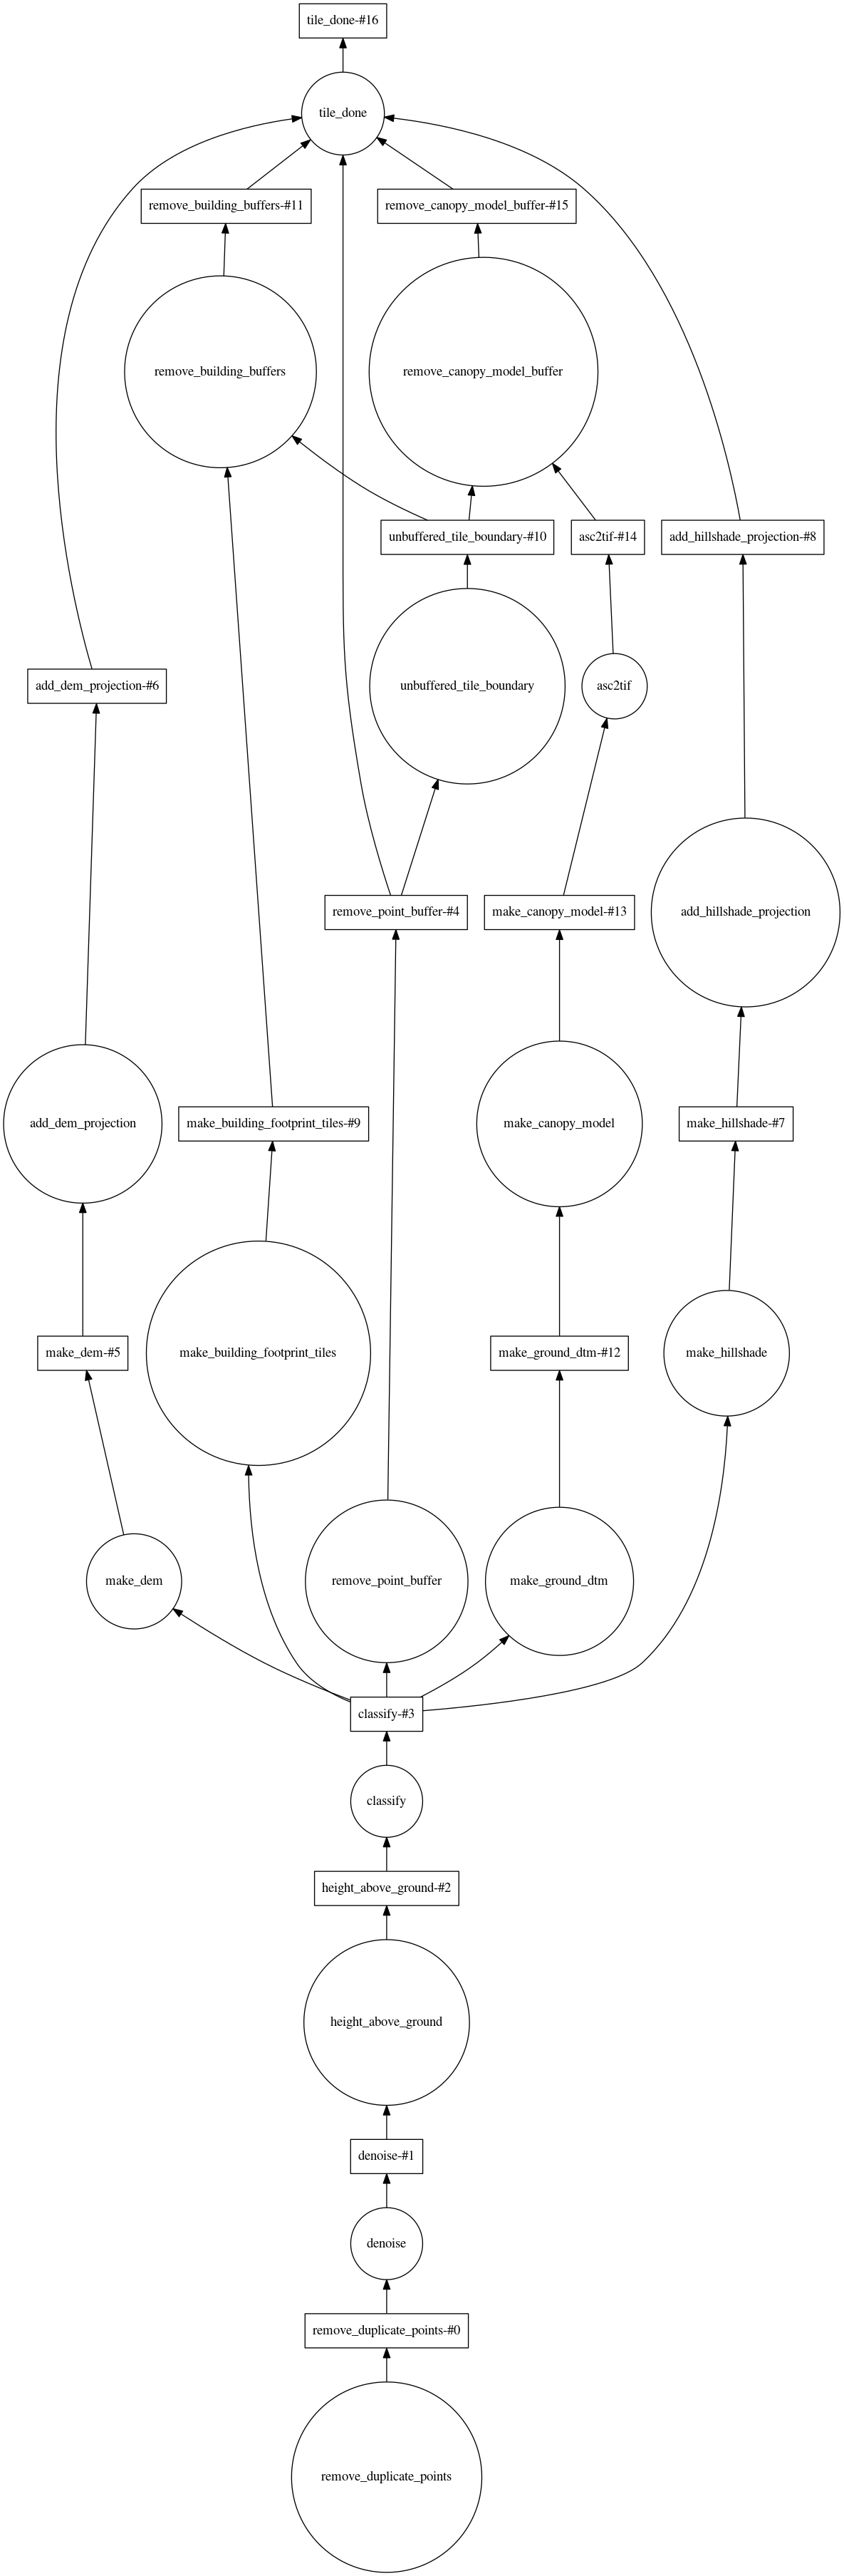

In [26]:
example_tile_graph = c.get(dsk, 'tile_done-{}'.format(tile_ids[0]))
example_tile_graph.visualize()

In [27]:
# example_tile_graph = c.get(dsk, 'tile_done-{}'.format(tile_ids[0]))
# example_tile_result = c.compute(example_tile_graph)
# progress(example_tile_result)

Get Dask to determine how to get to the last state of the tile-processing pipeline, building a computational graph.

In [28]:
tiles_graph = c.get(dsk, 'tiles_done')

In [29]:
tiles_results = c.compute(tiles_graph) # this might take a while...

In [30]:
progress(tiles_results)

VBox()

In [32]:
failed = glob.glob(os.path.join(interim, 'failed', '*.txt'))
finished = [os.path.basename(tile).split('.')[0] for tile in glob.glob(os.path.join(interim, 'finished', '*.txt'))]

summary = '''Processing Summary
--------------------
{:,d} tiles finished processing
{:,d} tiles failed
'''.format(len(finished), len(failed))

print(summary)

Processing Summary
--------------------
0 tiles finished processing
0 tiles failed



In [ ]:
# c.cancel(tiles_results)

In [ ]:
%%time
# get rid of the .tfw and .kml files that LAStools generates
clean_dir(os.path.join(processed, 'rasters', 'DEM_tiles'), ['.tfw', '.kml'])

In [ ]:
%%time
# get rid of the .tfw and .kml files that LAStools generates
clean_dir(os.path.join(processed, 'rasters', 'hillshade_tiles'), ['.tfw', '.kml'])

In [ ]:
%%time
# get rid of the .asc and .dtm files that FUSION generates
clean_dir(os.path.join(interim, 'chm_tiles'), ['.asc', '.dtm'])

In [ ]:
c.close()
cluster.close()